In [138]:
import cv2
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import tensorflow as tf
import tqdm
from pathlib import Path
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers

In [130]:
W = 180; H = 135


def clockwise(xmin_, ymin_, xmax_, ymax_, w):
    ymin = xmin_
    ymax = xmax_
    xmin = w - ymax_
    xmax = w - ymin_
    return xmin, ymin, xmax, ymax

def clockwise_img(image):
    return np.rot90(image, -1)

def resize(x, y, pw, ph):
    x = int(x * W / pw)
    y = int(y * H / ph)
    return x, y

def resize_img(img, portrait=False):
    w = W; h = H
    if (portrait):
        img = clockwise_img(img)
    return cv2.resize(src=img, dsize=(w, h), interpolation=cv2.INTER_AREA)

In [131]:
YI = []
YB = []
NI = []
NB = []
RES = []

k = 0

# balls processing
annotations = pd.read_csv("dataset/balls/_annotations.csv")

for index, row in annotations.iterrows():
    portrait = False
    w, h, xmin, ymin, xmax, ymax = row[1], row[2], row[4], row[5], row[6], row[7]
    if (w < h):
        portrait = True
    img = resize_img(np.array(keras.preprocessing.image.load_img("dataset/balls/" + row[0])), portrait)
    if (portrait):
        w = w + h; h = w - h; w = w - h
        xmin, ymin, xmax, ymax = clockwise(xmin, ymin, xmax, ymax, w)
    xmin, ymin = resize(xmin, ymin, w, h)
    xmax, ymax = resize(xmax, ymax, w, h)
    img = tf.cast(img, tf.float32) / 255.0
    YI.append(img)
    YB.append(np.array([xmin, ymin, xmax, ymax]))
    RES.append(1)
    
# no-balls processing
for img_path in Path("dataset/no_balls/").glob('*.jpg'):
    img = np.array(keras.preprocessing.image.load_img(img_path))
    h, w, _ = np.shape(img)
    portrait = False
    if (h > w):
        portrait = True
    img = resize_img(img, portrait)
    img = tf.cast(img, tf.float32) / 255.0
    NI.append(img)
    NB.append(np.array([0, 0, 0, 0]))
    RES.append(0)

YI = np.array(YI)
YB = np.array(YB)
NI = np.array(NI)
NB = np.array(NB)

In [132]:
print(len(YI))
print(len(NI))
print(YI[0].dtype)
print(YI[0])

399
323
float32
[[[0.05490196 0.0627451  0.07058824]
  [0.04705882 0.05490196 0.0627451 ]
  [0.05098039 0.05098039 0.06666667]
  ...
  [0.17254902 0.21568628 0.24313726]
  [0.1764706  0.21176471 0.24313726]
  [0.17254902 0.21960784 0.24705882]]

 [[0.10196079 0.09803922 0.09411765]
  [0.09411765 0.09019608 0.08627451]
  [0.08235294 0.08235294 0.08235294]
  ...
  [0.18039216 0.21176471 0.22352941]
  [0.2        0.21960784 0.24313726]
  [0.1764706  0.21176471 0.23137255]]

 [[0.11372549 0.10196079 0.08235294]
  [0.11372549 0.09803922 0.09019608]
  [0.11764706 0.10196079 0.09411765]
  ...
  [0.1882353  0.20784314 0.23921569]
  [0.19607843 0.21960784 0.24705882]
  [0.18431373 0.21176471 0.23921569]]

 ...

 [[0.05098039 0.05098039 0.05098039]
  [0.05098039 0.05098039 0.05098039]
  [0.04705882 0.04705882 0.04705882]
  ...
  [0.5254902  0.5803922  0.6117647 ]
  [0.5137255  0.5647059  0.59607846]
  [0.49803922 0.5529412  0.5803922 ]]

 [[0.04705882 0.04705882 0.04705882]
  [0.05098039 0.05098

In [165]:
# please move along this pile...
travy, travn = 350, 283
valvy, valvn = 390, 316
tesvy, tesvn = 399, 323
RES = np.array(RES)
YI_train = YI[0:travy]
YB_train = YB[0:travy]
YI_valid = YI[travy:valvy]
YB_valid = YB[travy:valvy]
YI_test = YI[valvy:tesvy]
YB_test = YB[valvy:tesvy]
YR_train = RES[0:travy]
YR_valid = RES[travy:valvy]
YR_test = RES[valvy:tesvy]
NI_train = NI[0:travn]
NB_train = NB[0:travn]
NI_valid = NI[travn:valvn]
NB_valid = NB[travn:valvn]
NI_test = NI[valvn:tesvn]
NB_test = NB[valvn:tesvn]
NR_train = RES[tesvy:tesvy+travn]
NR_valid = RES[tesvy+travn:tesvy+valvn]
NR_test = RES[tesvy+valvn:tesvy+tesvn]
I_train = np.concatenate((YI_train, NI_train))
I_valid = np.concatenate((YI_valid, NI_valid))
I_test = np.concatenate((YI_test, NI_test))
B_train = np.concatenate((YB_train, NB_train))
B_valid = np.concatenate((YB_valid, NB_valid))
B_test = np.concatenate((YB_test, NB_test))
R_train = np.concatenate((YR_train, NR_train))
R_valid = np.concatenate((YR_valid, NR_valid))
R_test = np.concatenate((YR_test, NR_test))

In [166]:
print("",
      len(I_train), len(I_valid), len(I_test), "\n",
      len(B_train), len(B_valid), len(B_test), "\n",
      len(R_train), len(R_valid), len(R_test))

 633 73 16 
 633 73 16 
 633 73 16


[ 95  63 122  89]


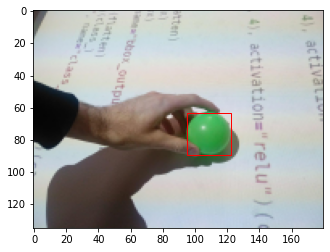

In [167]:
i = YI[3]
b = YB[3]
print(b)

fig, ax = plt.subplots()
ax.imshow(i)
rect = patches.Rectangle((b[0], b[1]), b[2]-b[0], b[3]-b[1], linewidth=1, edgecolor="r", facecolor="none")
ax.add_patch(rect)

In [168]:
out = ["not found", "found"]

In [185]:
input_shape = tf.keras.layers.Input((H, W, 3))
gen_model = layers.Conv2D(16, 3, padding="same", activation="relu")(input_shape)
gen_model = layers.MaxPooling2D()(gen_model)
gen_model = layers.Conv2D(32, 3, padding="same", activation="relu")(gen_model)
gen_model = layers.MaxPooling2D()(gen_model)
gen_model = layers.Conv2D(64, 3, padding="same", activation="relu")(gen_model)
gen_model = layers.MaxPooling2D()(gen_model)
gen_model = layers.Flatten()(gen_model)
img_model = layers.Dense(128, activation="relu")(gen_model)
img_model = layers.Dense(2, name="is_found")(img_model)
box_model = layers.Dense(128, activation="relu")(gen_model)
box_model = layers.Dense(64, activation="relu")(box_model)
box_model = layers.Dense(32, activation="relu")(box_model)
box_model = layers.Dense(4, activation="sigmoid", name="bbox")(box_model)

model = tf.keras.Model(input_shape, outputs=[img_model, box_model])
losses = {"is_found":tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), "bbox":tf.keras.losses.MSE}
model.compile(loss=losses, optimizer='Adam', metrics=['accuracy'])
model.summary()

Model: "model_12"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_18 (InputLayer)          [(None, 135, 180, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_47 (Conv2D)             (None, 135, 180, 16  448         ['input_18[0][0]']               
                                )                                                                 
                                                                                                  
 max_pooling2d_46 (MaxPooling2D  (None, 67, 90, 16)  0           ['conv2d_47[0][0]']              
 )                                                                                         

In [186]:
result = model.fit(I_train, 
                   {"is_found": R_train, "bbox": B_train}, 
                   validation_data=(I_valid, {"is_found": R_valid, "bbox": B_valid}), 
                   batch_size=32, 
                   epochs=30,
                   shuffle=True,
                   verbose=1)

Epoch 1/30
20/20 [==============================] - 14s 635ms/step - loss: 3453.7776 - is_found_loss: 1.1247 - bbox_loss: 3452.6528 - is_found_accuracy: 0.5371 - bbox_accuracy: 0.4392 - val_loss: 2859.0527 - val_is_found_loss: 1.0629 - val_bbox_loss: 2857.9897 - val_is_found_accuracy: 0.5479 - val_bbox_accuracy: 0.4521
Epoch 2/30
20/20 [==============================] - 11s 547ms/step - loss: 3450.8516 - is_found_loss: 1.0245 - bbox_loss: 3449.8274 - is_found_accuracy: 0.4992 - bbox_accuracy: 0.4502 - val_loss: 2858.9399 - val_is_found_loss: 0.9500 - val_bbox_loss: 2857.9897 - val_is_found_accuracy: 0.5479 - val_bbox_accuracy: 0.4247
Epoch 3/30
20/20 [==============================] - 11s 549ms/step - loss: 3450.5249 - is_found_loss: 0.6944 - bbox_loss: 3449.8298 - is_found_accuracy: 0.6035 - bbox_accuracy: 0.4502 - val_loss: 2858.5720 - val_is_found_loss: 0.5803 - val_bbox_loss: 2857.9919 - val_is_found_accuracy: 0.6986 - val_bbox_accuracy: 0.4521
Epoch 4/30
20/20 [===================

In [187]:
model.save_weights('weights')
model.save('model.h5')

[array([[-2.9433396, -1.5520124]], dtype=float32), array([[1., 1., 1., 1.]], dtype=float32)]
found


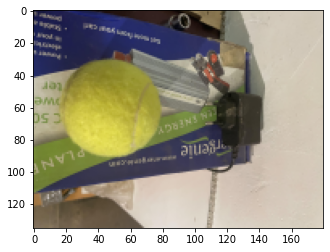

In [199]:
res = model.predict((I_test[0])[tf.newaxis, ...])
print(res)
print(out[np.argmax(res[0])])

plt.imshow(I_test[0])

[array([[12.176704 , -5.4663773]], dtype=float32), array([[1., 1., 1., 1.]], dtype=float32)]
not found


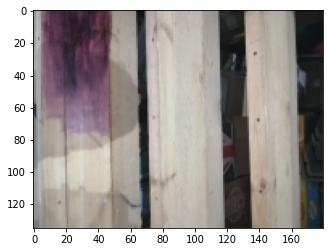

In [200]:
res = model.predict((I_test[12])[tf.newaxis, ...])
print(res)
print(out[np.argmax(res[0])])

plt.imshow(I_test[12])

In [192]:
print(len(I_test))

16


In [201]:
correct = 0
total = len(I_test)

for i in range(total):
    res = model.predict((I_test[i])[tf.newaxis, ...])
    x = np.argmax(res[0])
    if (x == R_test[i]):
        correct += 1
    print(x, R_test[i])
        
print(correct, "correct out of", total, "total.")
print("Test data accuracy:", correct*100/total, "%")

1 1
0 1
1 1
1 1
0 1
0 1
1 1
1 1
0 1
0 0
0 0
0 0
0 0
0 0
0 0
0 0
12 correct out of 16 total.
Test data accuracy: 75.0 %
